In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import geopy.distance
import math
import radartrack as rt
from PIL import Image as Image
from pprint import pprint
import beeview
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature
import glob
import os
import re

In [3]:
data = pd.read_csv('coors_menzel_panos.txt', sep=';', header=None)

In [4]:
data.head()

,0,1,2
0,Fig_5_A_B_Hive,"50°48'51.83""N","8°52'20.67""E"
1,Fig_5_A_B_Feeder,"50°49'3.68""N","8°52'14.60""E"
2,Fig_5_A_B_Release_site,"50°49'10.94""N","8°52'40.14""E"
3,Fig_6_A_B_C_Hive,"50°48'51.83""N","8°52'20.67""E"
4,Fig_6_A_B_C_Feeder_F1,"50°48'58.31""N","8°52'33.31""E"


In [5]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'S' or direction == 'W':
        dd *= -1
    return dd;

def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

def parse_dms(dms):
    parts = re.split('[^\d\.\w]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])
    lng = dms2dd(parts[4], parts[5], parts[6], parts[7])

    return [lat, lng]

def convert_coords(coords):
    """ convert the gps coordinates to the coordinates used by beeview """
    
    radar_coords = (50.814512, 8.872433) # from google maps
    
    dist_y = geopy.distance.geodesic(radar_coords,(coords[0],radar_coords[1])).m
    dist_x = geopy.distance.geodesic(radar_coords,(radar_coords[0],coords[1])).m
    
    if radar_coords[1] > coords[1]:
        dist_x *= (-1)
        
    if radar_coords[0] > coords[0]:
        dist_y *= (-1)
    
    return (dist_x,dist_y)

In [6]:
# convert the dms coordinates to dd coordinates

res = []
for i in range(data.shape[0]):
    res.append([i]+parse_dms(data.loc[i,1]+" "+data.loc[i,2]))

In [7]:
# save as csv txt

np.savetxt("coords_dd.txt", res, delimiter=",", fmt="%10.10f")

In [8]:
# load from disk

coords_to_render = np.genfromtxt("coords_dd.txt", delimiter=",")

In [9]:
# get the names of the places (e.g. "Fig_5_A_B_Hive")

labels = data[0].tolist()

In [10]:
# start movie maker and load scene 

movie_maker = rt.movie.MovieMaker(scene='hessen_2016') 

In [11]:
markers = []

for i, coords in enumerate(coords_to_render):

    movie_maker.renderer.mode = beeview.Renderer.BeeEye
    movie_maker.renderer.set_ommatidium_size(1)

    p = convert_coords((coords[1],coords[2]))
    
    markers.append(rt.map.Marker(p,size=50, label=labels[i]))

    pos = movie_maker.to_3D_coordinates(p, height = 4)
    movie_maker.renderer.position = pos

    # west
    movie_maker.renderer.direction = [-1,0,0]

    image = movie_maker.renderer.render()

    # save the image
    Image.fromarray(image).save("menzel_panos_1px/beeview_west_"+labels[i]+".png")

    # change direction to east
    movie_maker.renderer.direction = [1,0,0]

    image = movie_maker.renderer.render()

    # save the image
    Image.fromarray(image).save("menzel_panos_1px/beeview_east_"+labels[i]+".png")
    
"""
    # panoramic image
    movie_maker.renderer.mode = beeview.Renderer.Panoramic
    image = movie_maker.renderer.render()

    # save the image
    Image.fromarray(image).save("menzel_panos_1px/pano_"+labels[i]+".png")
"""

'\n    # panoramic image\n    movie_maker.renderer.mode = beeview.Renderer.Panoramic\n    image = movie_maker.renderer.render()\n\n    # save the image\n    Image.fromarray(image).save("menzel_panos_1px/pano_"+labels[i]+".png")\n'

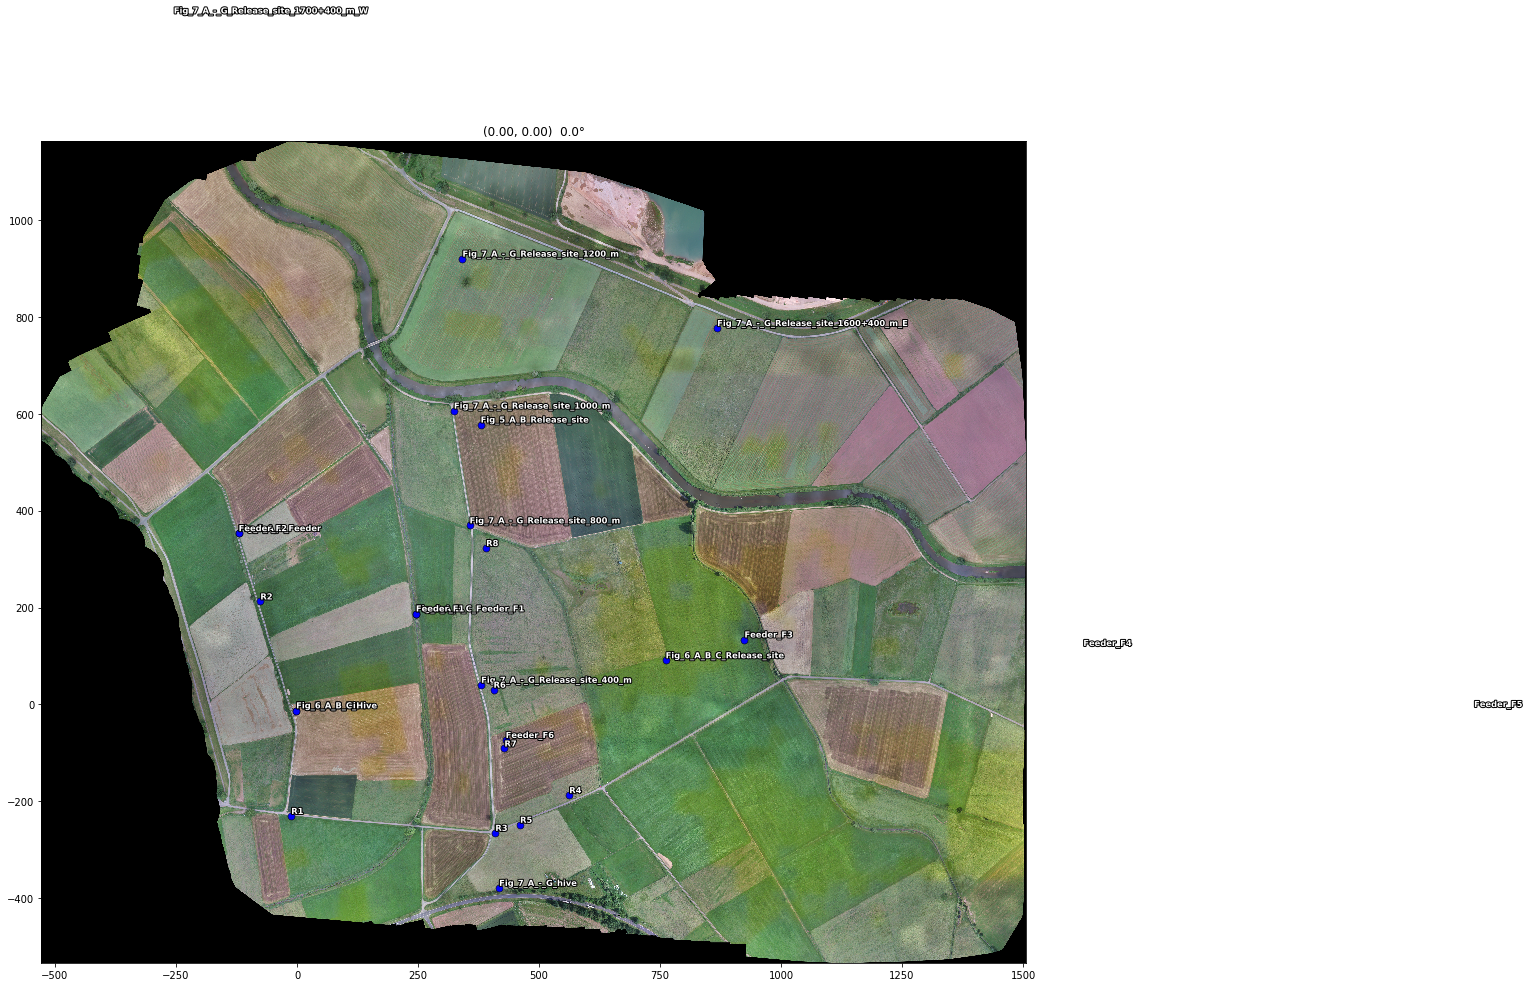

In [12]:
# plot the positions
plotter = rt.plot.Plotter()
plotter.new_figure(figsize=(16, 12)) \
       .set_map( rt.data.maps['drone_map', 'color_small']) \
       .set_markers(markers) \
       .plot() \
       .show()

In [13]:
# calculate the michelson contrast for all images

# load beeviews from disk
images = []
ids = []
for filename in glob.glob('menzel_panos_1px/beeview*.png'):
    
    ids.append(os.path.splitext(os.path.basename(filename))[0])
    
    images.append((np.array(Image.open(filename)) @ [0.299, 0.587, 0.114])/255)
    
images = np.array(images)

In [14]:
images.shape

(48, 131, 112)

In [15]:
images_michelson = images.reshape(images.shape[0],images.shape[1]*images.shape[2]).copy() # make that each image is 1 array

In [16]:
images_michelson[images_michelson == 0] = np.nan
images_michelson[images_michelson == 1] = np.nan

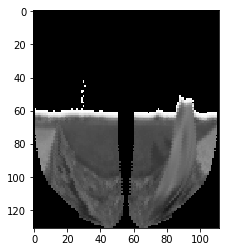

In [17]:
im = np.copy(images_michelson[0].reshape(131,112))
im[np.isnan(im)] = 0
plt.imshow(im, cmap="gray")
plt.show()

In [18]:
contrast = (np.nanmax(images_michelson, axis=1) - np.nanmin(images_michelson, axis=1))/(np.nanmax(images_michelson, axis=1) + np.nanmin(images_michelson, axis=1))

In [19]:
# mask of the ground area
images_michelson = images_michelson.reshape(48,131,112)
images_michelson[:,0:68,:] = np.nan

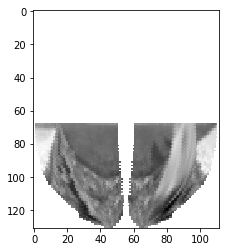

In [20]:
im = np.copy(images_michelson[0])
im[np.isnan(im)] = 0
plt.imshow(images_michelson[0], cmap="gray")
plt.show()

In [21]:
images_michelson = images_michelson.reshape(48,131*112) # make that each image is 1 array

In [22]:
contrast_masked = (np.nanmax(images_michelson, axis=1) - np.nanmin(images_michelson, axis=1))/(np.nanmax(images_michelson, axis=1) + np.nanmin(images_michelson, axis=1))

In [23]:
df = pd.DataFrame(data = {"ID": ids, "contrast": contrast, "contrast_masked": contrast_masked})
df.head()

,ID,contrast,contrast_masked
0,beeview_east_Feeder_F1,0.827707,0.718450
1,beeview_east_Feeder_F2,0.768956,0.691832
2,beeview_east_Feeder_F3,0.724495,0.508960
3,beeview_east_Feeder_F6,0.649897,0.348952
4,beeview_east_Fig_5_A_B_Feeder,0.768956,0.691832


In [24]:
df.to_csv("contrasts.csv", index=False)

In [25]:
print("contrast_mean: " + str(contrast.mean()))
print("contrast_std: " + str(contrast.std()))
print("contrast_masked_mean: " + str(contrast_masked.mean()))
print("contrast_masked_std: " + str(contrast_masked.std()))

contrast_mean: 0.720722688324
contrast_std: 0.0656481194598
contrast_masked_mean: 0.541240429303
contrast_masked_std: 0.146159825732


In [26]:
print(images.max())
print(images.min())

1.0
0.0


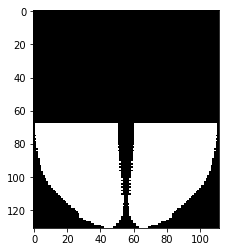

In [27]:
mask = images[0].copy()
mask[mask!=0] = 1
mask[0:68,:] = 0
mask = mask.astype(int)
mask = mask.astype(bool)

plt.imshow(mask, cmap="gray")
plt.show()

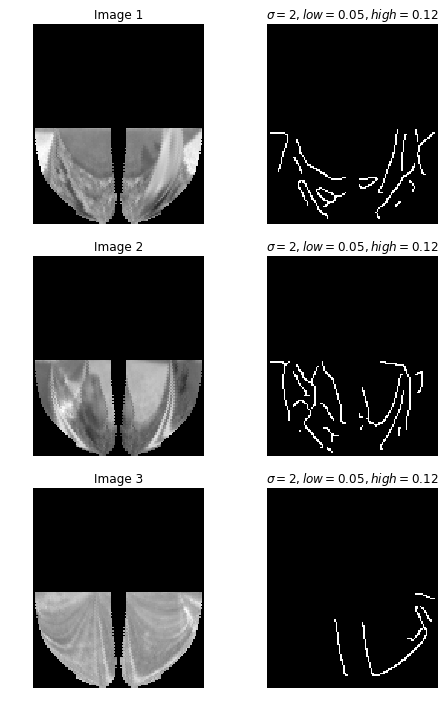

In [28]:
im1 = images[0].copy()
edges1 = feature.canny(im1, sigma=2, low_threshold=0.05, high_threshold=0.12, mask=mask)
im1[~mask] = 0

im2 = images[1].copy()
edges2 = feature.canny(im2, sigma=2, low_threshold=0.05, high_threshold=0.12, mask=mask)
im2[~mask] = 0

im3 = images[3].copy()
edges3 = feature.canny(im3, sigma=2, low_threshold=0.05, high_threshold=0.12, mask=mask)
im3[~mask] = 0

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=2, figsize=(7, 10),
                                    sharex=True, sharey=True)
ax1[0].imshow(im1, cmap=plt.cm.gray)
ax1[0].axis('off')
ax1[0].set_title('Image 1')

ax1[1].imshow(edges1, cmap=plt.cm.gray)
ax1[1].axis('off')
ax1[1].set_title('$\sigma=2, low=0.05, high=0.12$')

ax2[0].imshow(im2, cmap=plt.cm.gray)
ax2[0].axis('off')
ax2[0].set_title('Image 2')

ax2[1].imshow(edges2, cmap=plt.cm.gray)
ax2[1].axis('off')
ax2[1].set_title('$\sigma=2, low=0.05, high=0.12$')

ax3[0].imshow(im3, cmap=plt.cm.gray)
ax3[0].axis('off')
ax3[0].set_title('Image 3')

ax3[1].imshow(edges3, cmap=plt.cm.gray)
ax3[1].axis('off')
ax3[1].set_title('$\sigma=2, low=0.05, high=0.12$')

fig.tight_layout()

plt.show()

In [29]:
sigma = 2
low_threshold = 0.05
high_threshold = 0.12

sum_edges = []
for im in images:    
    edges = feature.canny(im,sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold, mask=mask)
    sum_edges.append(np.sum(edges))

sum_edges = np.array(sum_edges)
sum_edges_rel = sum_edges/np.sum(mask)

In [30]:
# sum edges relative ist geteilt duch die anzahl der pixel in der maske
df = pd.DataFrame(data = {"ID": ids, "contrast": contrast, "contrast_masked": contrast_masked, "sum_edges": sum_edges, "sum_edges_relative": sum_edges_rel })
df.head()

,ID,contrast,contrast_masked,sum_edges,sum_edges_relative
0,beeview_east_Feeder_F1,0.827707,0.718450,446,0.087041
1,beeview_east_Feeder_F2,0.768956,0.691832,502,0.097970
2,beeview_east_Feeder_F3,0.724495,0.508960,50,0.009758
3,beeview_east_Feeder_F6,0.649897,0.348952,210,0.040984
4,beeview_east_Fig_5_A_B_Feeder,0.768956,0.691832,502,0.097970


In [31]:
df.to_csv("edges.csv", index=False)

In [32]:
print("edges_mean: " + str(sum_edges.mean()))
print("edges_std: " + str(sum_edges.std()))
print("edges_rel_mean: " + str(sum_edges_rel.mean()))
print("edges_rel_std: " + str(sum_edges_rel.std()))

edges_mean: 288.708333333
edges_std: 179.538988144
edges_rel_mean: 0.0563443273484
edges_rel_std: 0.0350388345325
